In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
data = {}
pillars = ["busi", "econ", "educ", "envi", "gove", "heal", "pers", "safe", "soci"]
for i in pillars:
    train_df = pd.read_csv("data/{0}_train.csv".format(i)).drop("Unnamed: 0", axis = 1)
    test_df = pd.read_csv("data/{0}_test.csv".format(i)).drop("Unnamed: 0", axis = 1)
    data[i] = {"test" : test_df, "train" : train_df}

In [2]:
score_table = pd.read_csv("data/scores.csv")
prosperity_table = score_table[["country","year","prosperity"]]
# Most prosperous country and year
prosperity_table.sort_values("prosperity", ascending=False).head(5)

,country,year,prosperity
1149,New Zealand,2014,78.914742
1000,New Zealand,2013,78.832643
576,Sweden,2010,78.657402
1147,Norway,2014,78.500937
725,Sweden,2011,78.487949


In [3]:
score_table["most_impact"] = score_table[pillars].sub(score_table["prosperity"],axis=0).iloc[:,:-1].abs().T.idxmax()
score_table.head()

,Unnamed: 0,country,year,busi,econ,educ,envi,gove,heal,pers,safe,soci,prosperity,most_impact
0,0,Afghanistan,2007,35.308167,53.251713,22.494400,39.293343,29.760307,51.600807,32.290104,37.240280,37.691658,37.658975,econ
1,1,Angola,2007,27.057371,51.743580,35.916668,47.982162,30.910105,57.914005,45.123459,53.325123,44.954544,43.880780,busi
2,2,Albania,2007,40.626377,57.979511,56.318413,51.049442,42.531654,74.527748,60.275913,68.989883,41.740612,54.893284,heal
3,3,United Arab Emirates,2007,52.791740,67.167816,59.942955,62.051479,48.831993,77.575127,49.087570,80.370224,52.181824,61.111192,safe
4,4,Argentina,2007,47.438419,62.476505,51.995552,64.909729,45.032742,74.439102,63.805622,68.519714,48.400772,58.557573,heal


In [4]:
pillar_table = pd.pivot_table(
    score_table[["country","year","most_impact"]],
    values="most_impact",index="country",
    columns="year", aggfunc="first")
pillar_table.head()

year,2007,2008,2009,2010,2011,2012,2013,2014
country,,,,,,,,
Afghanistan,econ,econ,econ,heal,heal,heal,heal,heal
Albania,heal,heal,heal,heal,heal,heal,heal,heal
Algeria,heal,heal,heal,heal,heal,heal,heal,heal
Angola,busi,busi,busi,busi,busi,heal,heal,heal
Argentina,heal,heal,heal,pers,pers,pers,pers,pers


In [5]:
most_important_pillars = pillar_table.mode(axis=1).iloc[:,0]
most_important_pillars

country
Afghanistan    heal
Albania        heal
Algeria        heal
Angola         busi
Argentina      pers
               ... 
Venezuela      gove
Vietnam        pers
Yemen          heal
Zambia         educ
Zimbabwe       gove
Name: 0, Length: 149, dtype: object

In [6]:
top_growth = ["Togo","Zimbabwe","Chad","Georgia","Macedonia"]
most_important_pillars.loc[top_growth[:5]]

country
Togo         safe
Zimbabwe     gove
Chad         educ
Georgia      heal
Macedonia    safe
Name: 0, dtype: object

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_classification

In [8]:
for i in pillars: 
    columns = [col for col in data[i]['train'].columns if col[-4:]!="year" and col[:4]!="rank" and col not in ["country","isonum","isocode"]]
    tmpX = data[i]['train'][columns].select_dtypes(np.number)
    rank = "rank_" + i 
    # tmpX = tmpX.drop(columns = [rank])
    tmpX = tmpX.drop(columns = [i])
    tmpy = data[i]['train'][i]
    
    # ohotyr = pd.get_dummies(tmpX['year'])
    # tmpX = tmpX.drop(columns = ['year'])
    
    mod = LinearRegression()
    mod.fit(tmpX, tmpy)
    impt = mod.coef_
    
    tmp_coeff = pd.DataFrame([tmpX.columns, impt]).T.sort_values(1, ascending=False)
    tp3 = tmp_coeff.iloc[:3]
    bm3 = tmp_coeff.iloc[-3:]
    # important_categories
    print("Most Impactful Categories on " + i + "\n", tp3.values
          ,  "\n \n Least Impactful Categories on " + i + "\n", bm3.values, "\n")

Most Impactful Categories on busi
 [['ippr' 2.4785666187535074]
 ['logis' 2.0406800839176795]
 ['affs' 2.0249854499059343]] 
 
 Least Impactful Categories on busi
 [['bband' -0.012618482704600587]
 ['redu' -0.029696075619645886]
 ['elcostlnl' -0.4783941947585029]] 

Most Impactful Categories on econ
 [['gdp5' 18.61007125605273]
 ['eqi' 5.717482698722488]
 ['amp' 2.674101549294211]] 
 
 Least Impactful Categories on econ
 [['povdday' -0.1256187804258374]
 ['urate' -0.30384484908788073]
 ['edi' -1.1422207638759407]] 

Most Impactful Categories on educ
 [['qslnl' 1.714573675931544]
 ['teryrs' 1.6305879049648782]
 ['secyrs' 0.6457913772168496]] 
 
 Least Impactful Categories on educ
 [['edqualsc' 0.03838032887706233]
 ['Ginih15' -13.976619531601534]
 ['gbrata' -17.24460175621022]] 

Most Impactful Categories on envi
 [['pestreg' 0.3752748037874074]
 ['improved_drinkwater' 0.2240982761674628]
 ['terrestprotect' 0.14914001529663068]] 
 
 Least Impactful Categories on envi
 [['fwateruse' -0.0

In [9]:
X = pd.concat([
    data["busi"]["test"][["ippr","logis",'affs',"bband","redu","elcostlnl"]],
    data["econ"]["test"][["gdp5","eqi","amp","povdday","urate","edi"]],
    data["educ"]["test"][["qslnl","teryrs","secyrs","edqualsc","Ginih15","gbrata"]],
    data["envi"]["test"][["pestreg","improved_drinkwater","terrestprotect","fwateruse","fishstock","airpollution"]],
    data["gove"]["test"][["womenparl","rlaw","geff","ticpi","vapvt","rqual"]],
    data["heal"]["test"][["leb","impsan","imeas","Obesity","tblnl","meandiabetes"]],
    data["pers"]["test"][["propright","lgbt_rights","civlib","rrgov","rrsoc","deathpen"]],
    data["safe"]["test"][["tdeathslnl5","bdeathslnl","refugee_oriln","warcasual","pts","homilnl"]],
    data["soci"]["test"][["vtf"]]
],axis=1)
X.head()

,ippr,logis,affs,bband,redu,elcostlnl,gdp5,eqi,amp,povdday,...,rrgov,rrsoc,deathpen,tdeathslnl5,bdeathslnl,refugee_oriln,warcasual,pts,homilnl,vtf
0,2.457773,2.069573,3.852955,0.004795,26.472107,8.151823,0.029082,0.715496,3.438251,20.203930,...,8.0,7.8,1,8.180225,5.276663,11.330479,3.0,4.666667,1.864207,20.623501
1,2.257915,2.542980,3.236488,0.412784,31.007937,6.421622,0.017570,0.434404,2.034871,30.129999,...,5.0,2.9,0,-0.693147,-4.298536,6.084814,0.0,3.666667,2.383776,25.100000
2,2.896221,2.770000,3.737438,6.573716,20.825397,6.197258,0.027832,0.889969,3.392698,1.060000,...,2.2,0.3,0,-0.415888,-4.298536,8.154903,0.0,2.000000,1.393474,50.644501
3,5.475348,3.539098,5.424749,11.558400,4.285714,3.157000,0.017219,0.770421,5.295191,0.023814,...,4.6,1.5,1,-0.415888,-4.298536,2.298153,0.0,2.666667,-0.488302,0.000000
4,2.424609,2.986475,2.923875,15.573113,30.333333,3.214868,0.014131,0.776706,3.031993,1.750000,...,2.0,1.4,0,-0.693147,-4.298536,2.210600,0.0,2.666667,1.950704,77.016499


In [10]:
X.columns

Index(['ippr', 'logis', 'affs', 'bband', 'redu', 'elcostlnl', 'gdp5', 'eqi',
       'amp', 'povdday', 'urate', 'edi', 'qslnl', 'teryrs', 'secyrs',
       'edqualsc', 'Ginih15', 'gbrata', 'pestreg', 'improved_drinkwater',
       'terrestprotect', 'fwateruse', 'fishstock', 'airpollution', 'womenparl',
       'rlaw', 'geff', 'ticpi', 'vapvt', 'rqual', 'leb', 'impsan', 'imeas',
       'Obesity', 'tblnl', 'meandiabetes', 'propright', 'lgbt_rights',
       'civlib', 'rrgov', 'rrsoc', 'deathpen', 'tdeathslnl5', 'bdeathslnl',
       'refugee_oriln', 'warcasual', 'pts', 'homilnl', 'vtf'],
      dtype='object')

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR



In [12]:
score_table[score_table["country"] == "Togo"][pillars].diff().dropna()

,busi,econ,educ,envi,gove,heal,pers,safe,soci
132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
281,-2.118275,-0.887653,-1.522678,0.204544,0.945229,-0.817745,1.629627,1.032463,0.000000
430,0.403204,0.618271,2.123451,-0.045452,0.016447,0.112743,2.024693,-0.034649,0.000000
579,1.400745,0.146523,-0.889509,1.790726,0.352886,0.841755,7.148151,0.015717,0.386000
728,5.238546,0.887768,3.836079,2.568176,3.981892,0.225101,7.986214,-4.223518,2.500004
877,2.499786,0.284798,-1.587610,0.313702,0.275875,0.007732,-0.111107,0.944996,0.000000
1026,1.535404,0.150448,0.305672,0.477272,-0.676918,0.112408,0.925926,2.820484,-0.342909
1175,3.662376,0.542103,0.569719,0.272728,-0.093079,1.173340,1.921619,1.192116,5.136362


In [13]:
y_lst = [data["busi"]["train"][["country","year"]]]

for pillar in pillars:
    y_lst.append(data[pillar]["train"][[pillar,"rank_" + pillar]])
y = pd.concat(y_lst, axis=1)
y.head()

,country,year,busi,rank_busi,econ,rank_econ,educ,rank_educ,envi,rank_envi,gove,rank_gove,heal,rank_heal,pers,rank_pers,safe,rank_safe,soci,rank_soci
0,Afghanistan,2007,35.308167,127,53.251713,115,22.494400,143,39.293343,146,29.760307,142,51.600807,140,32.290104,142,37.240280,149,37.691658,144
1,Angola,2007,27.057371,146,51.743580,125,35.916668,125,47.982162,137,30.910105,137,57.914005,123,45.123459,113,53.325123,137,44.954544,107
2,Albania,2007,40.626377,107,57.979511,88,56.318413,72,51.049442,119,42.531654,91,74.527748,45,60.275913,68,68.989883,61,41.740612,124
3,United Arab Emirates,2007,52.791740,42,67.167816,43,59.942955,52,62.051479,50,48.831993,59,77.575127,34,49.087570,106,80.370224,16,52.181824,51
4,Argentina,2007,47.438419,68,62.476505,61,51.995552,92,64.909729,33,45.032742,84,74.439102,48,63.805622,55,68.519714,65,48.400772,78


In [14]:
feature_columns = ["year", 'ippr', 'logis', 'affs', 'bband', 'redu',
       'elcostlnl', 'gdp5', 'eqi', 'amp', 'povdday', 'urate', 'edi', 'qslnl',
       'teryrs', 'secyrs', 'edqualsc', 'Ginih15', 'gbrata', 'pestreg',
       'improved_drinkwater', 'terrestprotect', 'fwateruse', 'fishstock',
       'airpollution', 'womenparl', 'rlaw', 'geff', 'ticpi', 'vapvt', 'rqual',
       'leb', 'impsan', 'imeas', 'Obesity', 'tblnl', 'meandiabetes',
       'propright', 'lgbt_rights', 'civlib', 'rrgov', 'rrsoc', 'deathpen',
       'tdeathslnl5', 'bdeathslnl', 'refugee_oriln', 'warcasual', 'pts',
       'homilnl', 'vtf']

In [15]:
from sklearn.model_selection import train_test_split

train_X = pd.read_csv("data/merged_train.csv")[feature_columns]
# train_y = y.iloc[:,2:]
train_y = score_table[pillars]
test_X = pd.read_csv("data/merged_test.csv")[feature_columns]

train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.33)
print("train_X: ", train_X.shape, ", train_y: ", train_y.shape)
print("val_X: ", val_X.shape, ", val_y: ", val_y.shape)

train_X:  (798, 50) , train_y:  (798, 9)
val_X:  (394, 50) , val_y:  (394, 9)


In [16]:
lr_model = LinearRegression()
lr_model.fit(train_X, train_y)
lr_model.score(val_X,val_y)

0.9246189690834746

In [17]:
lr_model.predict(test_X)

array([[38.09382099, 51.18611744, 26.00395506, ..., 21.53427206,
        40.13357182, 38.97790307],
       [37.64407703, 50.13205634, 30.6172052 , ..., 46.30804399,
        58.93048538, 45.43188219],
       [50.97726264, 59.43825506, 59.05743179, ..., 64.96165362,
        67.91917194, 45.63305253],
       ...,
       [62.65471018, 56.44797157, 55.87053138, ..., 81.894171  ,
        57.65482453, 56.85383064],
       [48.74124304, 51.4997598 , 41.27907908, ..., 51.67266732,
        60.62091596, 52.97814118],
       [41.69971317, 55.32175587, 49.39971263, ..., 47.43957878,
        57.5508069 , 48.03789726]])

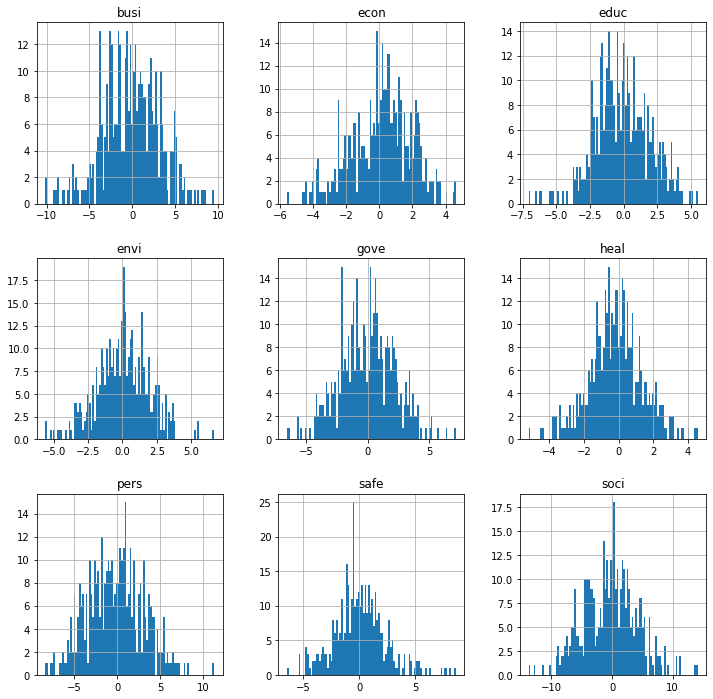

In [18]:
residual_df = (lr_model.predict(val_X) - val_y)[pillars]

fig, axes = plt.subplots(len(residual_df.columns)//3, 3, figsize=(12, 12))

i = 0
for triaxis in axes:
    for axis in triaxis:
        residual_df.hist(column = residual_df.columns[i], bins = 100, ax=axis)
        i = i+1

In [19]:
from sklearn import svm
from sklearn.multioutput import MultiOutputRegressor

# Create the Multioutput Regressor
muti_svr = MultiOutputRegressor(svm.SVR())
muti_svr.fit(train_X,train_y)
muti_svr.score(val_X,val_y)

0.22307776826600678

In [20]:
from sklearn.ensemble import RandomForestRegressor

rf_regr = RandomForestRegressor()
rf_regr.fit(train_X,train_y)
rf_regr.score(val_X,val_y)

0.9599743440101562

In [21]:
# from sklearn.decomposition import PCA

# n_lst = list(range(5, 50, 2))
# lr_scores, rf_scores = [], []
# for n in n_lst:
#     print("Components:", n)
#     pca = PCA(n_components=n)
#     train_X_pca = pca.fit_transform(train_X)
#     val_X_pca = pca.transform(val_X)

#     lr_model = LinearRegression()
#     lr_model.fit(train_X_pca, train_y)
#     lr_score = lr_model.score(val_X_pca,val_y)
#     #print("Linear Regression after PCA: ", lr_score)
#     lr_scores.append(lr_score)

#     rf_regr = RandomForestRegressor()
#     rf_regr.fit(train_X_pca,train_y)
#     rf_score = rf_regr.score(val_X_pca,val_y)
#     #print("Random Forest after PCA: ", rf_score)
#     rf_scores.append(rf_score)

Components: 5
Components: 7
Components: 9
Components: 11
Components: 13
Components: 15
Components: 17
Components: 19
Components: 21
Components: 23
Components: 25
Components: 27
Components: 29
Components: 31
Components: 33
Components: 35
Components: 37
Components: 39
Components: 41
Components: 43
Components: 45
Components: 47
Components: 49


Text(0.5, 1.0, 'Performance of models with different number of principal components')

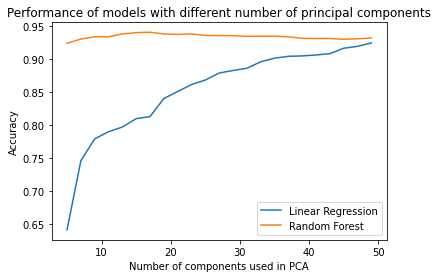

In [30]:
plt.plot(n_lst, lr_scores, label="Linear Regression")
plt.plot(n_lst, rf_scores, label="Random Forest")
plt.legend()
plt.xlabel("Number of components used in PCA")
plt.ylabel("Accuracy")
plt.title("Performance of models with different number of principal components")
plt.savefig("images/p")

In [23]:
print("Best PCA n = ",n_lst[np.argmax(rf_scores)])
print("Best Accuracy with Random Forest: ",rf_scores[np.argmax(rf_scores)])

Best PCA n =  17
Best Accuracy with Random Forest:  0.9404464779663684


In [24]:
# pca = PCA(n_components=15)
# train_X_pca = pca.fit_transform(train_X)
# val_X_pca = pca.transform(val_X)

# best_regr = RandomForestRegressor()
# best_regr.fit(train_X_pca,train_y)
# best_score = best_regr.score(val_X_pca,val_y)
# best_score

rf_regr = RandomForestRegressor()
rf_regr.fit(train_X,train_y)
rf_regr.score(val_X,val_y)

0.962013481692119

In [25]:
top_growth = top_growth[:5]
top_growth

['Togo', 'Zimbabwe', 'Chad', 'Georgia', 'Macedonia']

In [26]:
# test_X = pd.read_csv("merged_test.csv")[feature_columns]
raw_test = pd.read_csv("data/merged_test.csv")
togo_X = raw_test[raw_test["country"] == "Togo"][feature_columns]
rf_regr.predict(togo_X)

array([[40.18395639, 50.01771572, 31.92911963, 58.10699299, 35.84083681,
        53.80361168, 55.88599583, 58.7379837 , 34.75551064],
       [40.18395639, 50.01771572, 31.92911963, 58.10699299, 35.84083681,
        53.80361168, 55.88599583, 58.7379837 , 34.75551064]])

In [27]:
rf_regr.predict(togo_X).mean(axis=1)

array([46.58463593, 46.58463593])

Text(0.5, 1.0, 'Prosperity Score of Togo')

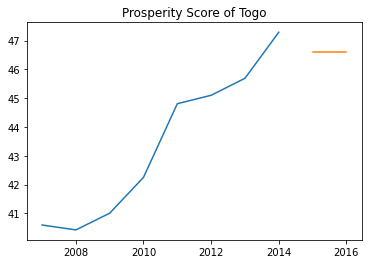

In [28]:
plt.plot([i for i in range(2007,2015)], list(score_table[score_table["country"]=="Togo"]["prosperity"]))
plt.plot([2015,2016], list(rf_regr.predict(togo_X).mean(axis=1)))
plt.title("Prosperity Score of Togo")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=da4f784b-a8aa-48e9-8797-5366ef739e9c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>